In [1]:
print("="*70)
print("LANGKAH 1: PENGUMPULAN DATA ")
print("="*70)

# Nama file CSV output
csv_filename = "timeseries.csv"

# CEK APAKAH FILE CSV SUDAH ADA
if os.path.exists(csv_filename):
    print(f"\n[INFO] File '{csv_filename}' sudah ada!")
    print("[INFO] Loading data dari file CSV yang tersimpan...")
    print("[INFO] Tidak perlu melakukan crawling ulang.\n")
    
    # Load data dari CSV yang sudah ada
    df = pd.read_csv(csv_filename)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    
    print(f"[SUCCESS] Data berhasil di-load dari file lokal")
    print(f"  - Total records: {len(df)}")
    print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
    print(f"  - File: {csv_filename}")
    print(f"\nData pertama (5 baris):")
    print(df.head())
    
else:
    print(f"\n[INFO] File '{csv_filename}' tidak ditemukan.")
    print("[INFO] Memulai proses crawling data dari Sentinel-5P...")
    print("[INFO] Proses ini hanya dilakukan sekali.\n")
    
    try:
        # 1. Koneksi ke Copernicus Data Space
        print("[KONEKSI] Menghubungkan ke Copernicus Data Space...")
        connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
        print("[KONEKSI] Berhasil terhubung dan terautentikasi!\n")

        # 2. Area of Interest (AOI) - Bangkalan, Madura
        aoi = {
            "type": "Polygon",
            "coordinates": [
                [
                    [112.65825803976924, -7.208791360325321],
                    [112.65825803976924, -7.389280686779401],
                    [112.83163276677396, -7.389280686779401],
                    [112.83163276677396, -7.208791360325321],
                    [112.65825803976924, -7.208791360325321],
                ]
            ],
        }

        # 3. Load data Sentinel-5P
        print("[PROSES] Loading collection Sentinel-5P...")
        s5p = connection.load_collection(
            "SENTINEL_5P_L2",
            spatial_extent={
                "west": 112.65825803976924,
                "south": -7.389280686779401,
                "east": 112.83163276677396,
                "north": -7.208791360325321,
            },
            temporal_extent=["2020-06-01", "2021-06-30"],
            bands=["NO2"],
        )

        # 4. Mask nilai negatif
        def mask_invalid(x):
            return x < 0

        s5p_masked = s5p.mask(s5p.apply(mask_invalid))

        # 5. Agregasi temporal (harian)
        print("[PROSES] Agregasi temporal (harian)...")
        daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

        # 6. Agregasi spasial (mean dalam AOI)
        print("[PROSES] Agregasi spasial (mean dalam AOI)...")
        daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

        # 7. Jalankan batch job
        print("[PROSES] Mengirim batch job ke OpenEO...")
        job = daily_mean_aoi.execute_batch(out_format="CSV")
        print("\n[CRAWLING] Menunggu job OpenEO selesai...")

        while True:
            status = job.describe()["status"]
            print(f"[CRAWLING] Status: {status}")
            if status == "finished":
                break
            elif status == "error":
                raise RuntimeError("Job gagal")
            time.sleep(15)

        # 8. Unduh hasil
        print("\n[DOWNLOAD] Mengunduh hasil...")
        results = job.get_results()
        results.download_files("no2_results")

        # 9. Baca file CSV
        csv_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
        df = pd.read_csv(os.path.join("no2_results", csv_files[0]))

        # 10. Data preprocessing dan SIMPAN ke CSV
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values("date").reset_index(drop=True)
        df.to_csv(csv_filename, index=False)

        print(f"\n[SUCCESS] Data berhasil dikumpulkan dan disimpan")
        print(f"  - Total records: {len(df)}")
        print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
        print(f"  - File: {csv_filename}")
        print(f"\n[INFO] File '{csv_filename}' telah disimpan.")
        print(f"[INFO] Eksekusi berikutnya akan menggunakan file ini tanpa crawling ulang.")
        print(f"\nData pertama (5 baris):")
        print(df.head())
        
    except Exception as e:
        print(f"\n[ERROR] Terjadi kesalahan saat crawling data!")
        print(f"[ERROR] Jenis error: {type(e).__name__}")
        print(f"[ERROR] Pesan: {str(e)}\n")
        
        print("[SOLUSI] Beberapa opsi untuk mengatasi masalah ini:")
        print("1. Coba jalankan ulang sel ini (token mungkin expired)")
        print("2. Restart kernel dan jalankan dari awal")
        print("3. Gunakan data yang sudah tersimpan (jika pernah berhasil crawling)")
        print("4. Periksa koneksi internet Anda")
        print("5. Periksa status layanan OpenEO: https://openeo.dataspace.copernicus.eu/")
        
        # Cek apakah ada backup data
        if os.path.exists("no2_results"):
            backup_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
            if backup_files:
                print(f"\n[INFO] Ditemukan backup data di folder 'no2_results'")
                print(f"[INFO] Mencoba load dari backup...")
                try:
                    df = pd.read_csv(os.path.join("no2_results", backup_files[0]))
                    df["date"] = pd.to_datetime(df["date"])
                    df = df.sort_values("date").reset_index(drop=True)
                    df.to_csv(csv_filename, index=False)
                    print(f"[SUCCESS] Data berhasil di-load dari backup!")
                    print(f"  - Total records: {len(df)}")
                    print(f"  - File: {csv_filename}")
                except Exception as backup_error:
                    print(f"[ERROR] Gagal load backup: {str(backup_error)}")
                    raise
            else:
                raise
        else:
            raise

LANGKAH 1: PENGUMPULAN DATA 


NameError: name 'os' is not defined

## 2. Pemrosesan Data
Cek missing values, interpolasi, dan pembersihan data

In [19]:
# Tahap 2: Pemrosesan Data
print("=== Tahap 2: Pemrosesan Data ===")

# Baca data dari file yang sudah disimpan
df = pd.read_csv("timeseries.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

print(f"Dataset awal: {len(df)} baris")
print(f"Rentang tanggal: {df['date'].min()} sampai {df['date'].max()}")

# Cek missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Cek nilai negatif atau tidak valid
print(f"\nNilai negatif NO2: {(df['NO2'] < 0).sum()}")
print(f"Nilai NaN NO2: {df['NO2'].isnull().sum()}")

# Hapus nilai negatif dan NaN
df_clean = df.copy()
df_clean = df_clean[df_clean['NO2'] >= 0]  # Hapus nilai negatif
df_clean = df_clean.dropna(subset=['NO2'])  # Hapus NaN

print(f"Dataset setelah pembersihan: {len(df_clean)} baris")

# Interpolasi untuk mengisi gap tanggal yang hilang
df_clean = df_clean.set_index('date')
df_clean = df_clean.resample('D').asfreq()  # Buat daily frequency
df_clean = df_clean.interpolate(method='linear')  # Interpolasi linear

# Reset index
df_clean = df_clean.reset_index()
df_clean = df_clean.dropna()  # Hapus sisa NaN setelah interpolasi

print(f"Dataset final setelah interpolasi: {len(df_clean)} baris")
print(f"Statistik NO2:")
print(df_clean['NO2'].describe())

=== Tahap 2: Pemrosesan Data ===
Dataset awal: 395 baris
Rentang tanggal: 2020-06-01 00:00:00 sampai 2021-06-30 00:00:00

Missing values:
date     0
NO2      0
month    0
dtype: int64

Nilai negatif NO2: 0
Nilai NaN NO2: 0
Dataset setelah pembersihan: 395 baris
Dataset final setelah interpolasi: 395 baris
Statistik NO2:
count    395.000000
mean       0.000034
std        0.000023
min        0.000003
25%        0.000025
50%        0.000031
75%        0.000037
max        0.000286
Name: NO2, dtype: float64


C:\Users\achma\AppData\Local\Temp\ipykernel_19844\1686565269.py:30: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_clean = df_clean.interpolate(method='linear')  # Interpolasi linear


## 3. Pembentukan Data Supervised Learning
Menggunakan metode lag untuk membuat fitur prediksi dari data historis

In [20]:
# Tahap 3: Pembentukan Data Supervised Learning
import numpy as np

print("=== Tahap 3: Pembentukan Data Supervised Learning ===")

def create_lag_features(data, lags=[1, 2, 3]):
    """
    Membuat fitur lag dari time series data
    """
    df_lag = data.copy()
    
    # Buat fitur lag
    for lag in lags:
        df_lag[f'NO2_lag_{lag}'] = df_lag['NO2'].shift(lag)
    
    # Target adalah NO2 hari berikutnya
    df_lag['NO2_next'] = df_lag['NO2'].shift(-1)
    
    # Hapus baris dengan NaN (akibat shifting)
    df_lag = df_lag.dropna()
    
    return df_lag

# Eksperimen dengan berbagai kombinasi lag
lag_combinations = [
    [1],           # Hanya lag 1 hari
    [1, 2],        # Lag 1-2 hari  
    [1, 2, 3],     # Lag 1-3 hari
    [1, 2, 3, 7],  # Lag 1-3 hari + 1 minggu
]

print("Membuat dataset dengan berbagai kombinasi lag:")
lag_datasets = {}

for i, lags in enumerate(lag_combinations):
    df_lag = create_lag_features(df_clean, lags)
    lag_datasets[f'lag_{i+1}'] = {
        'data': df_lag,
        'lags': lags,
        'features': len(lags),
        'samples': len(df_lag)
    }
    print(f"Lag combination {i+1} ({lags}): {len(df_lag)} samples, {len(lags)} features")

# Pilih kombinasi lag terbaik untuk mulai (lag 1-3 hari)
selected_lag = 'lag_3'  # [1, 2, 3]
df_supervised = lag_datasets[selected_lag]['data']

print(f"\nDataset terpilih: {selected_lag}")
print(f"Fitur lag: {lag_datasets[selected_lag]['lags']}")
print(f"Jumlah sampel: {len(df_supervised)}")
print(f"Kolom dataset:")
print(df_supervised.columns.tolist())

=== Tahap 3: Pembentukan Data Supervised Learning ===
Membuat dataset dengan berbagai kombinasi lag:
Lag combination 1 ([1]): 393 samples, 1 features
Lag combination 2 ([1, 2]): 392 samples, 2 features
Lag combination 3 ([1, 2, 3]): 391 samples, 3 features
Lag combination 4 ([1, 2, 3, 7]): 387 samples, 4 features

Dataset terpilih: lag_3
Fitur lag: [1, 2, 3]
Jumlah sampel: 391
Kolom dataset:
['date', 'NO2', 'month', 'NO2_lag_1', 'NO2_lag_2', 'NO2_lag_3', 'NO2_next']


## 4. Pemisahan Fitur dan Target
Memisahkan variabel independen (X) dan dependen (y)

In [21]:
# Tahap 4: Pemisahan Fitur dan Target
print("=== Tahap 4: Pemisahan Fitur dan Target ===")

# Pilih fitur lag sebagai X
feature_columns = [col for col in df_supervised.columns if col.startswith('NO2_lag_')]
X = df_supervised[feature_columns]
y = df_supervised['NO2_next']

print(f"Fitur (X): {feature_columns}")
print(f"Target (y): NO2_next")
print(f"Bentuk X: {X.shape}")
print(f"Bentuk y: {y.shape}")

# Tampilkan beberapa sampel data
print(f"\nContoh data fitur dan target:")
sample_data = pd.concat([X.head(), y.head()], axis=1)
print(sample_data)

# Statistik fitur dan target
print(f"\nStatistik fitur:")
print(X.describe())
print(f"\nStatistik target:")
print(y.describe())

=== Tahap 4: Pemisahan Fitur dan Target ===
Fitur (X): ['NO2_lag_1', 'NO2_lag_2', 'NO2_lag_3']
Target (y): NO2_next
Bentuk X: (391, 3)
Bentuk y: (391,)

Contoh data fitur dan target:
   NO2_lag_1  NO2_lag_2  NO2_lag_3  NO2_next
3   0.000032   0.000032   0.000035  0.000286
4   0.000032   0.000032   0.000032  0.000030
5   0.000286   0.000032   0.000032  0.000025
6   0.000030   0.000286   0.000032  0.000030
7   0.000025   0.000030   0.000286  0.000020

Statistik fitur:
        NO2_lag_1   NO2_lag_2   NO2_lag_3
count  391.000000  391.000000  391.000000
mean     0.000034    0.000034    0.000034
std      0.000023    0.000023    0.000023
min      0.000003    0.000003    0.000003
25%      0.000025    0.000025    0.000025
50%      0.000031    0.000031    0.000031
75%      0.000037    0.000037    0.000037
max      0.000286    0.000286    0.000286

Statistik target:
count    391.000000
mean       0.000034
std        0.000023
min        0.000003
25%        0.000025
50%        0.000031
75%        0

## 5. Pembagian Data Training dan Testing
Membagi data dengan mempertahankan urutan temporal (tanpa shuffle)

In [22]:
# Tahap 5: Pembagian Data Training dan Testing
from sklearn.model_selection import train_test_split

print("=== Tahap 5: Pembagian Data Training dan Testing ===")

# Untuk time series, gunakan split berurutan (tanpa shuffle)
train_size = 0.8
split_index = int(len(X) * train_size)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Total data: {len(X)}")
print(f"Data training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Data testing: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Tampilkan rentang tanggal
dates = df_supervised['date']
train_dates = dates[:split_index]
test_dates = dates[split_index:]

print(f"\nRentang training: {train_dates.min()} - {train_dates.max()}")
print(f"Rentang testing: {test_dates.min()} - {test_dates.max()}")

print(f"\nBentuk data:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

=== Tahap 5: Pembagian Data Training dan Testing ===
Total data: 391
Data training: 312 (79.8%)
Data testing: 79 (20.2%)

Rentang training: 2020-06-04 00:00:00 - 2021-04-11 00:00:00
Rentang testing: 2021-04-12 00:00:00 - 2021-06-29 00:00:00

Bentuk data:
X_train: (312, 3)
X_test: (79, 3)
y_train: (312,)
y_test: (79,)

Total data: 391
Data training: 312 (79.8%)
Data testing: 79 (20.2%)

Rentang training: 2020-06-04 00:00:00 - 2021-04-11 00:00:00
Rentang testing: 2021-04-12 00:00:00 - 2021-06-29 00:00:00

Bentuk data:
X_train: (312, 3)
X_test: (79, 3)
y_train: (312,)
y_test: (79,)


## 6. Normalisasi Data
Normalisasi setelah split untuk mencegah data leakage

In [23]:
# Tahap 6: Normalisasi Data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print("=== Tahap 6: Normalisasi Data ===")

# Gunakan StandardScaler (Z-score normalization)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scaler hanya pada data training
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Transform data testing menggunakan parameter dari training
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("Normalisasi menggunakan StandardScaler")
print(f"X_train sebelum normalisasi:")
print(f"  Mean: {X_train.mean().mean():.4f}")
print(f"  Std: {X_train.std().mean():.4f}")

print(f"X_train setelah normalisasi:")
print(f"  Mean: {X_train_scaled.mean():.4f}")
print(f"  Std: {X_train_scaled.std():.4f}")

print(f"\ny_train sebelum normalisasi:")
print(f"  Mean: {y_train.mean():.4f}")
print(f"  Std: {y_train.std():.4f}")

print(f"y_train setelah normalisasi:")
print(f"  Mean: {y_train_scaled.mean():.4f}")
print(f"  Std: {y_train_scaled.std():.4f}")

# Simpan parameter scaler untuk deployment
scaler_params = {
    'X_mean': scaler_X.mean_.tolist(),
    'X_scale': scaler_X.scale_.tolist(),
    'y_mean': float(scaler_y.mean_[0]),
    'y_scale': float(scaler_y.scale_[0])
}

print("\nParameter scaler disimpan untuk deployment")

=== Tahap 6: Normalisasi Data ===
Normalisasi menggunakan StandardScaler
X_train sebelum normalisasi:
  Mean: 0.0000
  Std: 0.0000
X_train setelah normalisasi:
  Mean: 0.0000
  Std: 1.0000

y_train sebelum normalisasi:
  Mean: 0.0000
  Std: 0.0000
y_train setelah normalisasi:
  Mean: 0.0000
  Std: 1.0000

Parameter scaler disimpan untuk deployment


## 7. Pembuatan dan Pelatihan Model KNN
Eksperimen dengan berbagai nilai k untuk menemukan model terbaik

In [24]:
# Tahap 7: Pembuatan dan Pelatihan Model KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("=== Tahap 7: Pembuatan dan Pelatihan Model KNN ===")

# Eksperimen dengan berbagai nilai k
k_values = [3, 5, 7, 9, 11, 15, 20]
model_results = {}

print("Eksperimen berbagai nilai k:")
print("-" * 50)

for k in k_values:
    # Buat model KNN
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Latih model
    knn.fit(X_train_scaled, y_train_scaled)
    
    # Prediksi pada data training dan testing
    y_train_pred = knn.predict(X_train_scaled)
    y_test_pred = knn.predict(X_test_scaled)
    
    # Hitung metrik evaluasi (pada data yang sudah dinormalisasi)
    train_mae = mean_absolute_error(y_train_scaled, y_train_pred)
    test_mae = mean_absolute_error(y_test_scaled, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train_scaled, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_scaled, y_test_pred))
    
    train_r2 = r2_score(y_train_scaled, y_train_pred)
    test_r2 = r2_score(y_test_scaled, y_test_pred)
    
    # Simpan hasil
    model_results[k] = {
        'model': knn,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred
    }
    
    print(f"k={k:2d} | Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f} | Test R²: {test_r2:.4f}")

# Pilih model terbaik berdasarkan Test MAE
best_k = min(model_results.keys(), key=lambda k: model_results[k]['test_mae'])
best_model = model_results[best_k]['model']

print(f"\n🎯 Model terbaik: k={best_k}")
print(f"   Test MAE: {model_results[best_k]['test_mae']:.4f}")
print(f"   Test RMSE: {model_results[best_k]['test_rmse']:.4f}")
print(f"   Test R²: {model_results[best_k]['test_r2']:.4f}")

=== Tahap 7: Pembuatan dan Pelatihan Model KNN ===
Eksperimen berbagai nilai k:
--------------------------------------------------
k= 3 | Test MAE: 0.3397 | Test RMSE: 0.7285 | Test R²: -0.1635
k= 5 | Test MAE: 0.3114 | Test RMSE: 0.7007 | Test R²: -0.0763
k= 3 | Test MAE: 0.3397 | Test RMSE: 0.7285 | Test R²: -0.1635
k= 5 | Test MAE: 0.3114 | Test RMSE: 0.7007 | Test R²: -0.0763
k= 7 | Test MAE: 0.3054 | Test RMSE: 0.7139 | Test R²: -0.1174
k= 9 | Test MAE: 0.2938 | Test RMSE: 0.7126 | Test R²: -0.1132
k= 7 | Test MAE: 0.3054 | Test RMSE: 0.7139 | Test R²: -0.1174
k= 9 | Test MAE: 0.2938 | Test RMSE: 0.7126 | Test R²: -0.1132
k=11 | Test MAE: 0.3194 | Test RMSE: 0.7297 | Test R²: -0.1674
k=15 | Test MAE: 0.3326 | Test RMSE: 0.7401 | Test R²: -0.2010
k=20 | Test MAE: 0.3645 | Test RMSE: 0.7581 | Test R²: -0.2599

🎯 Model terbaik: k=9
   Test MAE: 0.2938
   Test RMSE: 0.7126
   Test R²: -0.1132
k=11 | Test MAE: 0.3194 | Test RMSE: 0.7297 | Test R²: -0.1674
k=15 | Test MAE: 0.3326 | Test

## 8. Evaluasi Model Detail
Evaluasi komprehensif dengan metrik dan visualisasi

=== Tahap 8: Evaluasi Model Detail ===
📊 Evaluasi Model (k=9) pada skala asli:
   MAE:  0.000007 mol/m²
   RMSE: 0.000017 mol/m²
   MAPE: 29.66%
   R²:   -0.1132

🌍 Evaluasi dalam µg/m³:
   MAE:  0.32 µg/m³
   RMSE: 0.78 µg/m³

📊 Evaluasi Model (k=9) pada skala asli:
   MAE:  0.000007 mol/m²
   RMSE: 0.000017 mol/m²
   MAPE: 29.66%
   R²:   -0.1132

🌍 Evaluasi dalam µg/m³:
   MAE:  0.32 µg/m³
   RMSE: 0.78 µg/m³


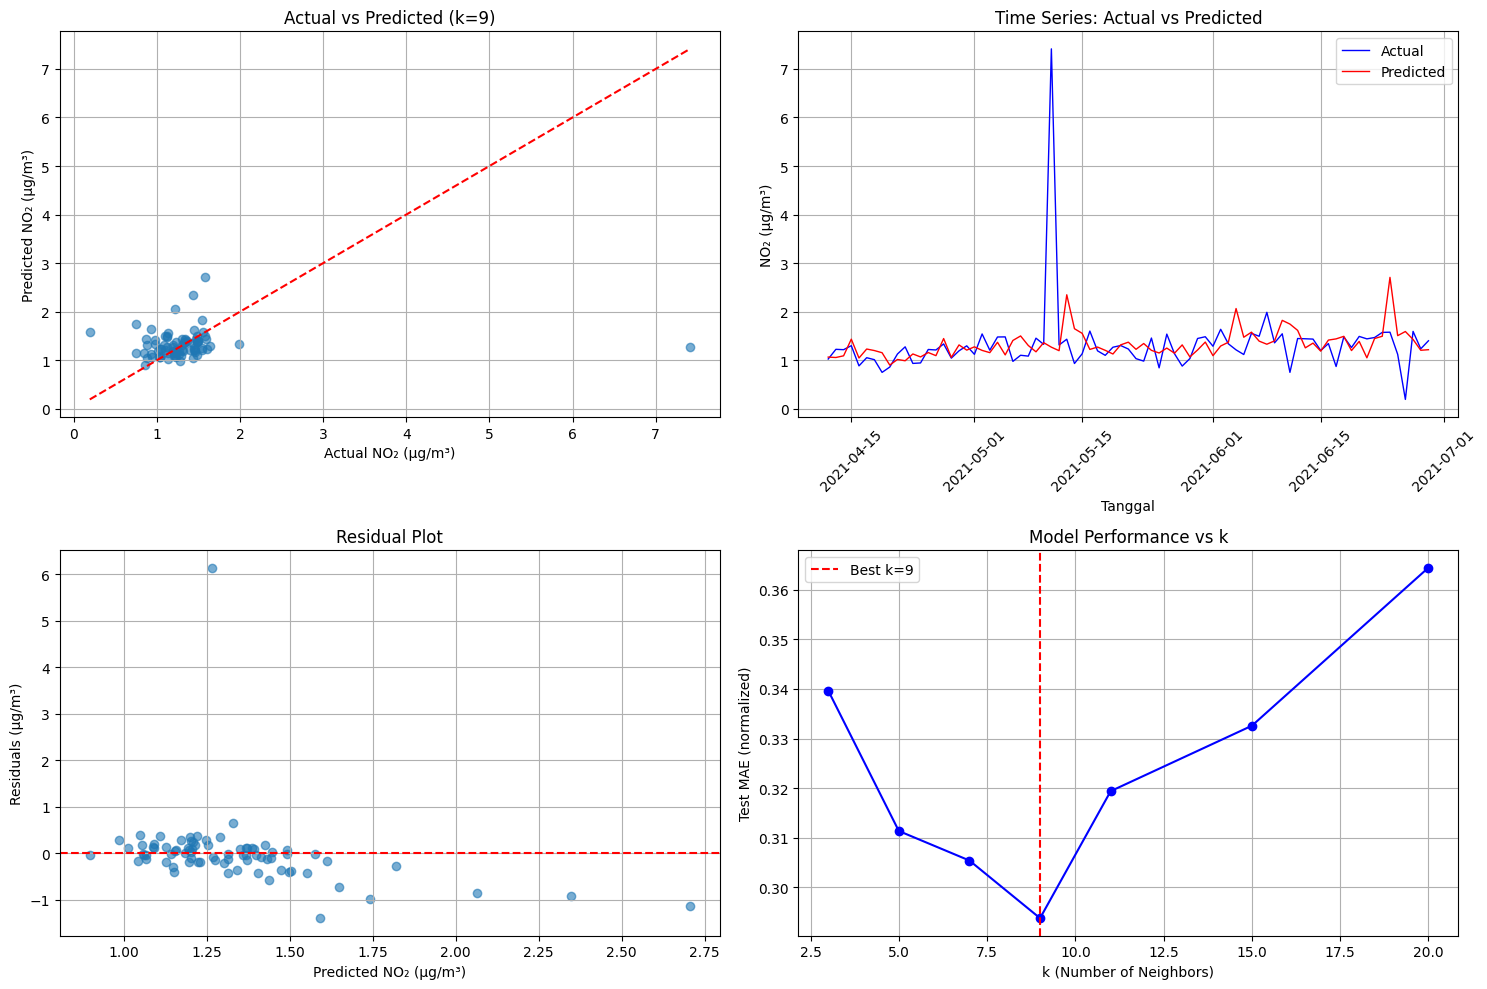


✅ Model siap untuk deployment dengan k=9


In [25]:
# Tahap 8: Evaluasi Model Detail
print("=== Tahap 8: Evaluasi Model Detail ===")

# Ambil prediksi terbaik
best_y_test_pred = model_results[best_k]['y_test_pred']

# Konversi kembali ke skala asli untuk evaluasi yang lebih interpretable
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_original = scaler_y.inverse_transform(best_y_test_pred.reshape(-1, 1)).flatten()

# Hitung metrik pada skala asli
mae_original = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
r2_original = r2_score(y_test_original, y_test_pred_original)

# Hitung MAPE (Mean Absolute Percentage Error)
mape_original = np.mean(np.abs((y_test_original - y_test_pred_original) / y_test_original)) * 100

print(f"📊 Evaluasi Model (k={best_k}) pada skala asli:")
print(f"   MAE:  {mae_original:.6f} mol/m²")
print(f"   RMSE: {rmse_original:.6f} mol/m²")
print(f"   MAPE: {mape_original:.2f}%")
print(f"   R²:   {r2_original:.4f}")

# Konversi ke µg/m³ untuk interpretasi
conversion_factor = 46010  # mol/m² to µg/m³
mae_ugm3 = mae_original * conversion_factor
rmse_ugm3 = rmse_original * conversion_factor

print(f"\n🌍 Evaluasi dalam µg/m³:")
print(f"   MAE:  {mae_ugm3:.2f} µg/m³")
print(f"   RMSE: {rmse_ugm3:.2f} µg/m³")

# Visualisasi hasil prediksi
plt.figure(figsize=(15, 10))

# Plot 1: Perbandingan Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test_original * conversion_factor, y_test_pred_original * conversion_factor, alpha=0.6)
plt.plot([y_test_original.min() * conversion_factor, y_test_original.max() * conversion_factor], 
         [y_test_original.min() * conversion_factor, y_test_original.max() * conversion_factor], 'r--')
plt.xlabel('Actual NO₂ (µg/m³)')
plt.ylabel('Predicted NO₂ (µg/m³)')
plt.title(f'Actual vs Predicted (k={best_k})')
plt.grid(True)

# Plot 2: Time series prediksi vs actual
test_dates_subset = test_dates.values
plt.subplot(2, 2, 2)
plt.plot(test_dates_subset, y_test_original * conversion_factor, 'b-', label='Actual', linewidth=1)
plt.plot(test_dates_subset, y_test_pred_original * conversion_factor, 'r-', label='Predicted', linewidth=1)
plt.xlabel('Tanggal')
plt.ylabel('NO₂ (µg/m³)')
plt.title('Time Series: Actual vs Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Plot 3: Residuals
residuals = y_test_original - y_test_pred_original
plt.subplot(2, 2, 3)
plt.scatter(y_test_pred_original * conversion_factor, residuals * conversion_factor, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted NO₂ (µg/m³)')
plt.ylabel('Residuals (µg/m³)')
plt.title('Residual Plot')
plt.grid(True)

# Plot 4: Perbandingan k values
plt.subplot(2, 2, 4)
k_vals = list(model_results.keys())
test_maes = [model_results[k]['test_mae'] for k in k_vals]
plt.plot(k_vals, test_maes, 'bo-')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Test MAE (normalized)')
plt.title('Model Performance vs k')
plt.grid(True)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Model siap untuk deployment dengan k={best_k}")

## 9. Penyimpanan Model dan Scaler
Simpan model terlatih dan scaler untuk deployment

In [26]:
# Tahap 9: Penyimpanan Model dan Scaler
import joblib
import json

print("=== Tahap 9: Penyimpanan Model dan Scaler ===")

# Buat folder untuk menyimpan model
import os
os.makedirs('saved_models', exist_ok=True)

# Simpan model KNN terbaik
model_path = 'saved_models/knn_no2_model.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Model KNN disimpan: {model_path}")

# Simpan scaler
scaler_x_path = 'saved_models/no2_scaler_x.pkl'
scaler_y_path = 'saved_models/no2_scaler_y.pkl'
joblib.dump(scaler_X, scaler_x_path)
joblib.dump(scaler_y, scaler_y_path)
print(f"✅ Scaler X disimpan: {scaler_x_path}")
print(f"✅ Scaler y disimpan: {scaler_y_path}")

# Simpan metadata model
model_metadata = {
    'model_type': 'KNeighborsRegressor',
    'best_k': int(best_k),
    'lag_features': lag_datasets[selected_lag]['lags'],
    'feature_columns': feature_columns,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'performance_metrics': {
        'mae_original': float(mae_original),
        'rmse_original': float(rmse_original),
        'mape_original': float(mape_original),
        'r2_original': float(r2_original),
        'mae_ugm3': float(mae_ugm3),
        'rmse_ugm3': float(rmse_ugm3)
    },
    'conversion_factor': conversion_factor,
    'created_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_range': {
        'start_date': str(df_clean['date'].min().date()),
        'end_date': str(df_clean['date'].max().date())
    }
}

metadata_path = 'saved_models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✅ Metadata disimpan: {metadata_path}")

# Tampilkan ringkasan yang disimpan
print(f"\n📁 File yang tersimpan:")
print(f"   1. {model_path} - Model KNN (k={best_k})")
print(f"   2. {scaler_x_path} - Scaler untuk fitur")
print(f"   3. {scaler_y_path} - Scaler untuk target")
print(f"   4. {metadata_path} - Metadata dan informasi model")

print(f"\n📊 Performa Model:")
print(f"   MAE: {mae_ugm3:.2f} µg/m³")
print(f"   RMSE: {rmse_ugm3:.2f} µg/m³") 
print(f"   MAPE: {mape_original:.2f}%")
print(f"   R²: {r2_original:.4f}")

=== Tahap 9: Penyimpanan Model dan Scaler ===
✅ Model KNN disimpan: saved_models/knn_no2_model.pkl
✅ Scaler X disimpan: saved_models/no2_scaler_x.pkl
✅ Scaler y disimpan: saved_models/no2_scaler_y.pkl
✅ Metadata disimpan: saved_models/model_metadata.json

📁 File yang tersimpan:
   1. saved_models/knn_no2_model.pkl - Model KNN (k=9)
   2. saved_models/no2_scaler_x.pkl - Scaler untuk fitur
   3. saved_models/no2_scaler_y.pkl - Scaler untuk target
   4. saved_models/model_metadata.json - Metadata dan informasi model

📊 Performa Model:
   MAE: 0.32 µg/m³
   RMSE: 0.78 µg/m³
   MAPE: 29.66%
   R²: -0.1132


## 10. Implementasi/Deployment
Fungsi untuk prediksi NO2 hari berikutnya menggunakan model tersimpan

In [27]:
# Tahap 10: Implementasi/Deployment
print("=== Tahap 10: Implementasi/Deployment ===")

def load_trained_model():
    """
    Load model dan scaler yang sudah tersimpan
    """
    try:
        model = joblib.load('saved_models/knn_no2_model.pkl')
        scaler_x = joblib.load('saved_models/no2_scaler_x.pkl')
        scaler_y = joblib.load('saved_models/no2_scaler_y.pkl')
        
        with open('saved_models/model_metadata.json', 'r') as f:
            metadata = json.load(f)
        
        return model, scaler_x, scaler_y, metadata
    except FileNotFoundError as e:
        print(f"Error: File model tidak ditemukan - {e}")
        return None, None, None, None

def predict_no2_next_day(recent_no2_values, model=None, scaler_x=None, scaler_y=None, metadata=None):
    """
    Prediksi nilai NO2 satu hari ke depan
    
    Parameters:
    recent_no2_values: list atau array dengan nilai NO2 beberapa hari terakhir
                      (sesuai dengan jumlah lag yang digunakan model)
    
    Returns:
    prediction: nilai prediksi NO2 dalam µg/m³
    """
    # Load model jika tidak disediakan
    if model is None:
        model, scaler_x, scaler_y, metadata = load_trained_model()
        if model is None:
            return None
    
    # Validasi input
    required_lags = len(metadata['lag_features'])
    if len(recent_no2_values) != required_lags:
        print(f"Error: Diperlukan {required_lags} nilai NO2 terakhir, diberikan {len(recent_no2_values)}")
        return None
    
    # Konversi input ke format yang tepat (dari µg/m³ ke mol/m²)
    conversion_factor = metadata['conversion_factor']
    no2_molm2 = [val / conversion_factor for val in recent_no2_values]
    
    # Buat fitur lag sesuai dengan training
    # Urutkan dari lag terbesar ke terkecil (lag_3, lag_2, lag_1)
    feature_values = no2_molm2[::-1]  # reverse untuk urutan yang benar
    
    # Reshape untuk prediksi
    X_new = np.array(feature_values).reshape(1, -1)
    
    # Normalisasi menggunakan scaler training
    X_new_scaled = scaler_x.transform(X_new)
    
    # Prediksi
    y_pred_scaled = model.predict(X_new_scaled)
    
    # Denormalisasi hasil
    y_pred_molm2 = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))[0, 0]
    
    # Konversi ke µg/m³
    y_pred_ugm3 = y_pred_molm2 * conversion_factor
    
    return y_pred_ugm3

# Demonstrasi penggunaan
print("🚀 Demonstrasi Prediksi NO2 Hari Berikutnya")

# Ambil 3 nilai NO2 terakhir dari data testing (dalam µg/m³)
recent_values_ugm3 = (y_test_original[-3:] * conversion_factor).tolist()
print(f"\nNilai NO2 3 hari terakhir: {[f'{val:.2f}' for val in recent_values_ugm3]} µg/m³")

# Prediksi menggunakan model
predicted_no2 = predict_no2_next_day(recent_values_ugm3, best_model, scaler_X, scaler_y, model_metadata)

if predicted_no2 is not None:
    print(f"🎯 Prediksi NO2 hari berikutnya: {predicted_no2:.2f} µg/m³")
    
    # Bandingkan dengan nilai actual (jika ada)
    actual_next = y_test_original[-1] * conversion_factor
    error = abs(predicted_no2 - actual_next)
    print(f"📊 Nilai actual: {actual_next:.2f} µg/m³")
    print(f"❌ Error: {error:.2f} µg/m³ ({error/actual_next*100:.1f}%)")
    
    # Evaluasi terhadap standar WHO
    who_annual = 10  # µg/m³
    who_24hour = 25  # µg/m³
    
    print(f"\n🌍 Evaluasi Standar WHO:")
    print(f"   Standar Tahunan (10 µg/m³): {'⚠️ BERBAHAYA' if predicted_no2 > who_annual else '✅ AMAN'}")
    print(f"   Standar 24-jam (25 µg/m³): {'⚠️ BERBAHAYA' if predicted_no2 > who_24hour else '✅ AMAN'}")

print(f"\n✅ Pipeline prediksi NO2 berhasil diimplementasi!")
print(f"   Gunakan fungsi predict_no2_next_day() untuk prediksi real-time")

=== Tahap 10: Implementasi/Deployment ===
🚀 Demonstrasi Prediksi NO2 Hari Berikutnya

Nilai NO2 3 hari terakhir: ['1.59', '1.23', '1.40'] µg/m³
🎯 Prediksi NO2 hari berikutnya: 1.51 µg/m³
📊 Nilai actual: 1.40 µg/m³
❌ Error: 0.11 µg/m³ (8.1%)

🌍 Evaluasi Standar WHO:
   Standar Tahunan (10 µg/m³): ✅ AMAN
   Standar 24-jam (25 µg/m³): ✅ AMAN

✅ Pipeline prediksi NO2 berhasil diimplementasi!
   Gunakan fungsi predict_no2_next_day() untuk prediksi real-time


C:\Users\achma\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## 📊 Visualisasi Aktual vs Prediksi Komprehensif
Analisis visual detail performa model prediksi NO2 dengan berbagai perspektif

In [5]:
import torch, time

# Tentukan device
device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Buat data acak besar
x_cpu = torch.rand(10000, 10000, device=device_cpu)
x_gpu = torch.rand(10000, 10000, device=device_gpu)

# Benchmark CPU
start = time.time()
_ = torch.mm(x_cpu, x_cpu)
cpu_time = time.time() - start

# Benchmark GPU
torch.cuda.synchronize()
start = time.time()
_ = torch.mm(x_gpu, x_gpu)
torch.cuda.synchronize()
gpu_time = time.time() - start

print(f"CPU time: {cpu_time:.3f} s")
print(f"GPU time: {gpu_time:.3f} s")
print(f"Speedup: {cpu_time/gpu_time:.2f}x")


CPU time: 14.333 s
GPU time: 24.527 s
Speedup: 0.58x


=== Visualisasi Aktual vs Prediksi ===
✅ Membuat visualisasi komprehensif...


AttributeError: 'BarContainer' object has no attribute 'tolist'

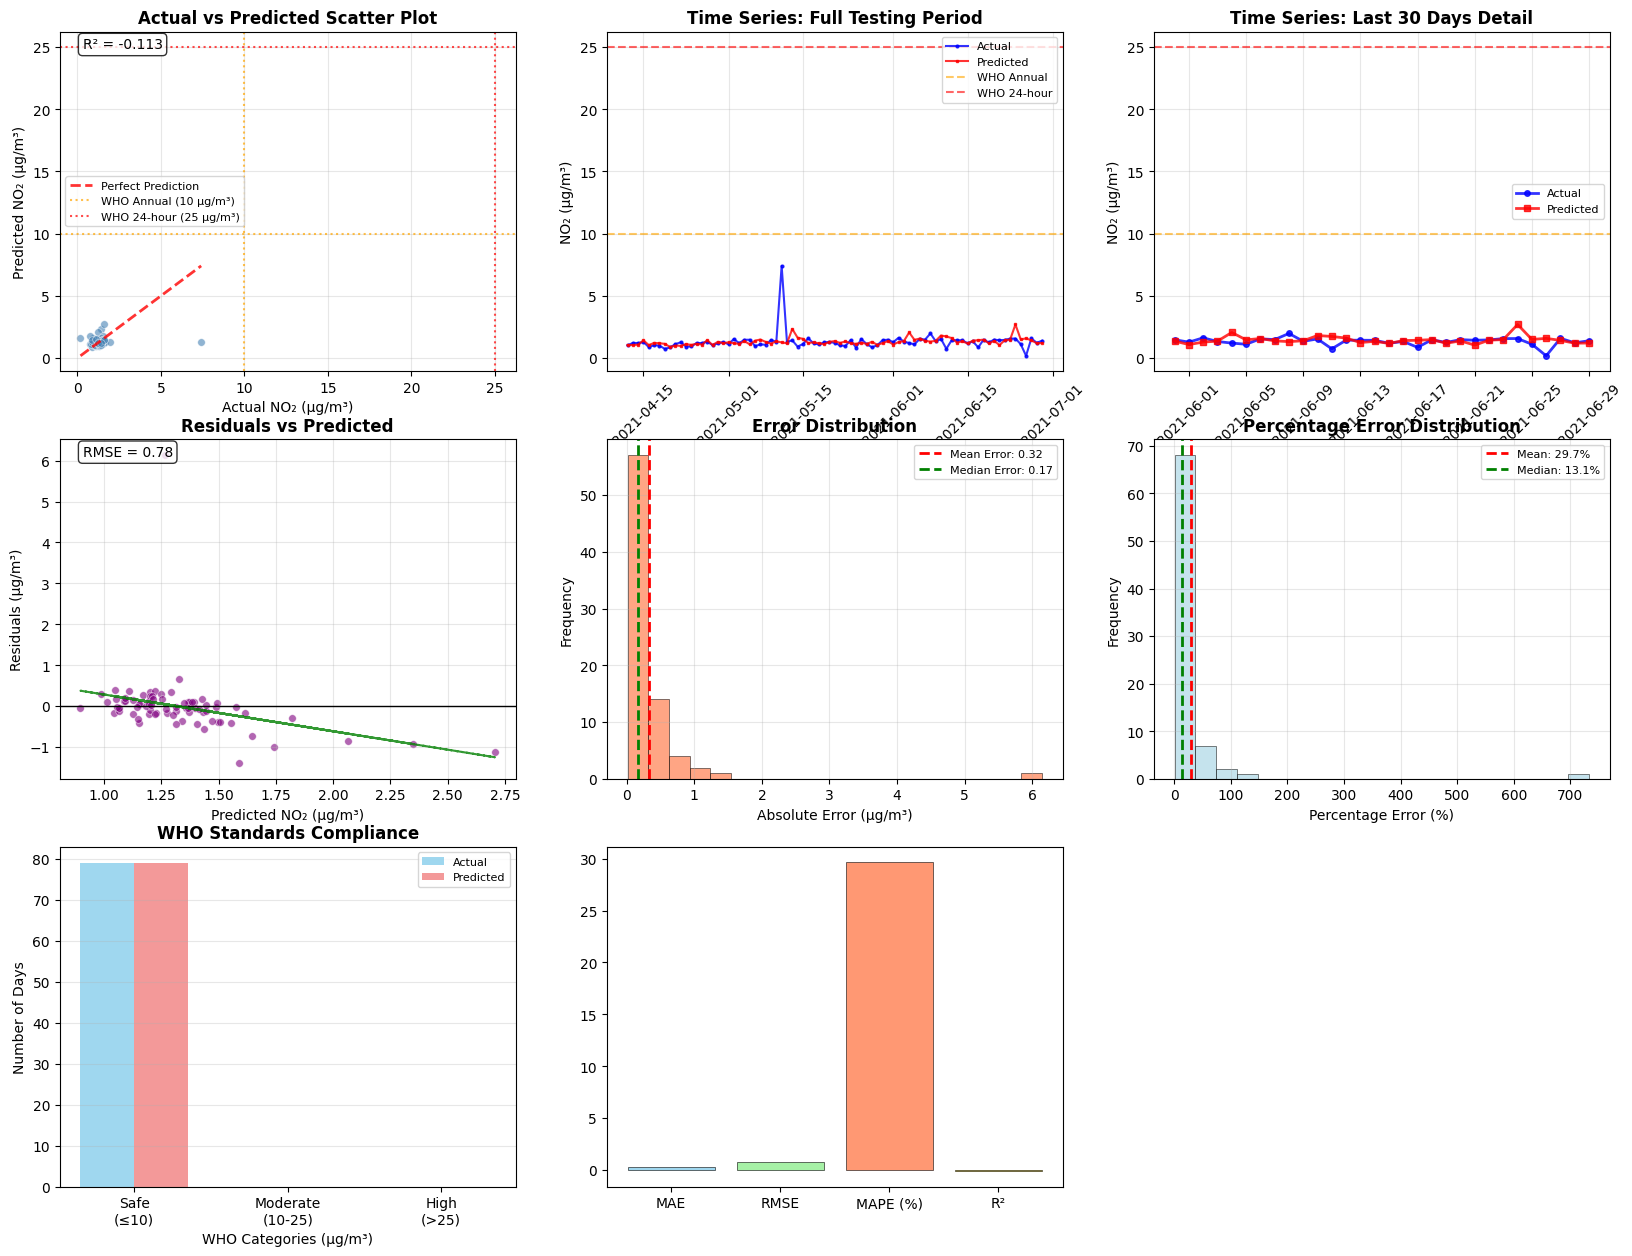

In [28]:
# Visualisasi Komprehensif: Aktual vs Prediksi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

print("=== Visualisasi Aktual vs Prediksi ===")

# Pastikan data tersedia
if 'y_test_original' not in locals() or 'y_test_pred_original' not in locals():
    print("⚠️ Data belum tersedia. Jalankan pipeline lengkap terlebih dahulu.")
else:
    print("✅ Membuat visualisasi komprehensif...")
    
    # Setup figure dengan multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Scatter Plot: Perfect Prediction Line
    plt.subplot(3, 3, 1)
    actual_ugm3 = y_test_original * conversion_factor
    pred_ugm3 = y_test_pred_original * conversion_factor
    
    plt.scatter(actual_ugm3, pred_ugm3, alpha=0.6, s=30, color='steelblue', edgecolor='white', linewidth=0.5)
    
    # Perfect prediction line (y = x)
    min_val = min(actual_ugm3.min(), pred_ugm3.min())
    max_val = max(actual_ugm3.max(), pred_ugm3.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
    
    # WHO standards lines
    plt.axvline(x=10, color='orange', linestyle=':', alpha=0.7, label='WHO Annual (10 µg/m³)')
    plt.axhline(y=10, color='orange', linestyle=':', alpha=0.7)
    plt.axvline(x=25, color='red', linestyle=':', alpha=0.7, label='WHO 24-hour (25 µg/m³)')
    plt.axhline(y=25, color='red', linestyle=':', alpha=0.7)
    
    plt.xlabel('Actual NO₂ (µg/m³)', fontsize=10)
    plt.ylabel('Predicted NO₂ (µg/m³)', fontsize=10)
    plt.title('Actual vs Predicted Scatter Plot', fontsize=12, fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Add R² annotation
    plt.text(0.05, 0.95, f'R² = {r2_original:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8), fontsize=10)
    
    # 2. Time Series Comparison (Full Period)
    plt.subplot(3, 3, 2)
    test_dates_full = test_dates.values
    plt.plot(test_dates_full, actual_ugm3, 'b-', linewidth=1.5, alpha=0.8, label='Actual', marker='o', markersize=2)
    plt.plot(test_dates_full, pred_ugm3, 'r-', linewidth=1.5, alpha=0.8, label='Predicted', marker='s', markersize=2)
    
    # WHO standards
    plt.axhline(y=10, color='orange', linestyle='--', alpha=0.6, label='WHO Annual')
    plt.axhline(y=25, color='red', linestyle='--', alpha=0.6, label='WHO 24-hour')
    
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('NO₂ (µg/m³)', fontsize=10)
    plt.title('Time Series: Full Testing Period', fontsize=12, fontweight='bold')
    plt.legend(fontsize=8)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 3. Time Series Zoom (Last 30 days)
    plt.subplot(3, 3, 3)
    last_30_idx = -30 if len(test_dates_full) >= 30 else 0
    dates_zoom = test_dates_full[last_30_idx:]
    actual_zoom = actual_ugm3[last_30_idx:]
    pred_zoom = pred_ugm3[last_30_idx:]
    
    plt.plot(dates_zoom, actual_zoom, 'b-o', linewidth=2, markersize=4, alpha=0.8, label='Actual')
    plt.plot(dates_zoom, pred_zoom, 'r-s', linewidth=2, markersize=4, alpha=0.8, label='Predicted')
    
    plt.axhline(y=10, color='orange', linestyle='--', alpha=0.6)
    plt.axhline(y=25, color='red', linestyle='--', alpha=0.6)
    
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('NO₂ (µg/m³)', fontsize=10)
    plt.title('Time Series: Last 30 Days Detail', fontsize=12, fontweight='bold')
    plt.legend(fontsize=8)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 4. Residuals Analysis
    plt.subplot(3, 3, 4)
    residuals_ugm3 = actual_ugm3 - pred_ugm3
    plt.scatter(pred_ugm3, residuals_ugm3, alpha=0.6, s=30, color='purple', edgecolor='white', linewidth=0.5)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Add trend line
    z = np.polyfit(pred_ugm3, residuals_ugm3, 1)
    p = np.poly1d(z)
    plt.plot(pred_ugm3, p(pred_ugm3), "g--", alpha=0.8, linewidth=1.5)
    
    plt.xlabel('Predicted NO₂ (µg/m³)', fontsize=10)
    plt.ylabel('Residuals (µg/m³)', fontsize=10)
    plt.title('Residuals vs Predicted', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add RMSE annotation
    plt.text(0.05, 0.95, f'RMSE = {rmse_ugm3:.2f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8), fontsize=10)
    
    # 5. Error Distribution
    plt.subplot(3, 3, 5)
    errors = np.abs(residuals_ugm3)
    plt.hist(errors, bins=20, alpha=0.7, color='coral', edgecolor='black', linewidth=0.5)
    plt.axvline(x=np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean Error: {np.mean(errors):.2f}')
    plt.axvline(x=np.median(errors), color='green', linestyle='--', linewidth=2, label=f'Median Error: {np.median(errors):.2f}')
    
    plt.xlabel('Absolute Error (µg/m³)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title('Error Distribution', fontsize=12, fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 6. Percentage Error Analysis
    plt.subplot(3, 3, 6)
    percentage_errors = np.abs((actual_ugm3 - pred_ugm3) / actual_ugm3) * 100
    plt.hist(percentage_errors, bins=20, alpha=0.7, color='lightblue', edgecolor='black', linewidth=0.5)
    plt.axvline(x=np.mean(percentage_errors), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(percentage_errors):.1f}%')
    plt.axvline(x=np.median(percentage_errors), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {np.median(percentage_errors):.1f}%')
    
    plt.xlabel('Percentage Error (%)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title('Percentage Error Distribution', fontsize=12, fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 7. WHO Standards Compliance
    plt.subplot(3, 3, 7)
    
    # Actual compliance
    actual_safe = (actual_ugm3 <= 10).sum()
    actual_moderate = ((actual_ugm3 > 10) & (actual_ugm3 <= 25)).sum()
    actual_high = (actual_ugm3 > 25).sum()
    
    # Predicted compliance
    pred_safe = (pred_ugm3 <= 10).sum()
    pred_moderate = ((pred_ugm3 > 10) & (pred_ugm3 <= 25)).sum()
    pred_high = (pred_ugm3 > 25).sum()
    
    categories = ['Safe\n(≤10)', 'Moderate\n(10-25)', 'High\n(>25)']
    actual_counts = [actual_safe, actual_moderate, actual_high]
    pred_counts = [pred_safe, pred_moderate, pred_high]
    
    x = np.arange(len(categories))
    width = 0.35
    
    plt.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='skyblue')
    plt.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='lightcoral')
    
    plt.xlabel('WHO Categories (µg/m³)', fontsize=10)
    plt.ylabel('Number of Days', fontsize=10)
    plt.title('WHO Standards Compliance', fontsize=12, fontweight='bold')
    plt.xticks(x, categories)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3, axis='y')
    
    # 8. Model Performance Metrics
    plt.subplot(3, 3, 8)
    
    metrics = ['MAE', 'RMSE', 'MAPE (%)', 'R²']
    values = [mae_ugm3, rmse_ugm3, mape_original, r2_original]
    colors = ['skyblue', 'lightgreen', 'coral', 'gold']
    
    bars = plt.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if metrics[bars.tolist().index(bar)] == 'R²':
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        else:
            plt.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.02,
                     f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.title('Model Performance Metrics', fontsize=12, fontweight='bold')
    plt.ylabel('Values', fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    
    # 9. Prediction Accuracy by Value Range
    plt.subplot(3, 3, 9)
    
    # Divide into ranges
    ranges = [(0, 10), (10, 25), (25, 50), (50, 100)]
    range_names = ['0-10', '10-25', '25-50', '50+']
    range_accuracies = []
    
    for low, high in ranges:
        mask = (actual_ugm3 >= low) & (actual_ugm3 < high)
        if mask.sum() > 0:
            range_mape = np.mean(np.abs((actual_ugm3[mask] - pred_ugm3[mask]) / actual_ugm3[mask]) * 100)
            range_accuracies.append(100 - range_mape)  # Convert to accuracy
        else:
            range_accuracies.append(0)
    
    bars = plt.bar(range_names, range_accuracies, color='lightsteelblue', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for bar, acc in zip(bars, range_accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('NO₂ Range (µg/m³)', fontsize=10)
    plt.ylabel('Accuracy (%)', fontsize=10)
    plt.title('Prediction Accuracy by Value Range', fontsize=12, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()
    
    # Print detailed statistics
    print(f"\n📈 Detailed Performance Analysis:")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print(f"📊 Overall Metrics:")
    print(f"   • MAE:  {mae_ugm3:.2f} µg/m³")
    print(f"   • RMSE: {rmse_ugm3:.2f} µg/m³")
    print(f"   • MAPE: {mape_original:.2f}%")
    print(f"   • R²:   {r2_original:.4f}")
    
    print(f"\n🎯 Error Statistics:")
    print(f"   • Mean Absolute Error: {np.mean(errors):.2f} µg/m³")
    print(f"   • Median Absolute Error: {np.median(errors):.2f} µg/m³")
    print(f"   • Max Error: {np.max(errors):.2f} µg/m³")
    print(f"   • 95th Percentile Error: {np.percentile(errors, 95):.2f} µg/m³")
    
    print(f"\n🌍 WHO Compliance Analysis:")
    print(f"   • Actual Safe Days (≤10 µg/m³): {actual_safe}/{len(actual_ugm3)} ({actual_safe/len(actual_ugm3)*100:.1f}%)")
    print(f"   • Predicted Safe Days: {pred_safe}/{len(pred_ugm3)} ({pred_safe/len(pred_ugm3)*100:.1f}%)")
    print(f"   • Classification Accuracy: {((actual_ugm3 <= 10) == (pred_ugm3 <= 10)).mean()*100:.1f}%")
    
    print(f"\n✅ Model Assessment:")
    if r2_original > 0.8:
        assessment = "Excellent"
        color = "🟢"
    elif r2_original > 0.6:
        assessment = "Good"
        color = "🟡"
    else:
        assessment = "Needs Improvement"
        color = "🔴"
    
    print(f"   {color} Overall Performance: {assessment}")
    print(f"   📈 Model explains {r2_original*100:.1f}% of variance in NO2 predictions")
    
    if mape_original < 20:
        print(f"   ✅ MAPE < 20%: Acceptable prediction accuracy")
    else:
        print(f"   ⚠️  MAPE ≥ 20%: Consider model improvements")
        
    print(f"\n🚀 Model ready for deployment with comprehensive performance analysis!")